In [1]:
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

In [2]:
data = yf.download(["AAPL", "GOOG", "BAS.DE", "BMW.DE", "RWE.DE", "DBK.DE"], start = "2010-01-01", end = "2018-12-31")

[*********************100%***********************]  6 of 6 completed


In [3]:
data.head()

Adj Close                                                         \
                AAPL     BAS.DE     BMW.DE     DBK.DE       GOOG     RWE.DE   
Date                                                                          
2009-12-31  6.426000        NaN        NaN        NaN  15.441621        NaN   
2010-01-04  6.526021  24.106218  19.280523  32.229893  15.610239  39.131069   
2010-01-05  6.537304  23.740726  19.436932  32.749939  15.541497  38.881386   
2010-01-06  6.433318  23.891220  19.737720  32.407475  15.149715  38.807625   
2010-01-07  6.421425  23.732660  19.912174  32.553341  14.797037  38.643059   

               Close                                   ...       Open  \
                AAPL     BAS.DE     BMW.DE     DBK.DE  ...     BMW.DE   
Date                                                   ...              
2009-12-31  7.526071        NaN        NaN        NaN  ...        NaN   
2010-01-04  7.643214  44.849998  32.049999  39.474529  ...  31.820000   
2010-01-05  7.656429  44.169998  32.310001  40.111465  ...  31.959999   
2010-01-06  7.534643  44.450001  32.810001  39.692020  ...  32.450001   
2010-01-07  7.520714  44.154999  33.099998  39.870674  ...  32.650002   

                                                  Volume             \
               DBK.DE       GOOG     RWE.DE         AAPL     BAS.DE   
Date                                                                  
2009-12-31        NaN  15.560426        NaN  352410800.0        NaN   
2010-01-04  38.837593  15.615220  68.222816  493729600.0  3245626.0   
2010-01-05  39.381317  15.620949  68.770988  601904800.0  3292371.0   
2010-01-06  39.909512  15.588072  68.202881  552160000.0  2345128.0   
2010-01-07  39.381317  15.178109  67.923813  477131200.0  2505352.0   

                                                          
               BMW.DE     DBK.DE         GOOG     RWE.DE  
Date                                                      
2009-12-31        NaN        NaN   48974884.0        NaN  
2010-01-04  1808170.0  4425924.0   78541293.0  2022078.0  
2010-01-05  1564182.0  5950810.0  120638494.0  2040667.0  
2010-01-06  2218604.0  5818935.0  159744526.0  1535087.0  
2010-01-07  2026145.0  4506202.0  257533695.0  1765257.0  

[5 rows x 36 columns]

In [4]:
data = data["Adj Close"]

In [5]:
data.head()

,AAPL,BAS.DE,BMW.DE,DBK.DE,GOOG,RWE.DE
Date,,,,,,
2009-12-31,6.426000,NaN,NaN,NaN,15.441621,NaN
2010-01-04,6.526021,24.106218,19.280523,32.229893,15.610239,39.131069
2010-01-05,6.537304,23.740726,19.436932,32.749939,15.541497,38.881386
2010-01-06,6.433318,23.891220,19.737720,32.407475,15.149715,38.807625
2010-01-07,6.421425,23.732660,19.912174,32.553341,14.797037,38.643059


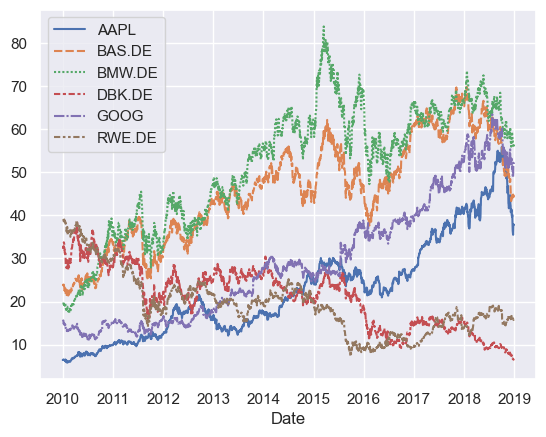

In [6]:
sns.lineplot(data = data);

In [7]:
data = pd.DataFrame(np.diff(np.log(data[1:]), axis=0) * 100, columns=data.columns)

In [8]:
data.head()

,AAPL,BAS.DE,BMW.DE,DBK.DE,GOOG,RWE.DE
0,0.172749,-1.527784,0.807952,1.600673,-0.441336,-0.640114
1,-1.603439,0.631904,1.535660,-1.051201,-2.553194,-0.189888
2,-0.185041,-0.665886,0.879976,0.449091,-2.355478,-0.424958
3,0.662639,-0.306180,-1.353524,3.578309,1.324303,-0.146938
4,-0.886061,-1.119375,-1.496368,-1.210318,-0.151272,1.169594


In [9]:
data = data.dropna(axis=0)

In [10]:
#for i in range(0, data.shape[1]):
 #   data.iloc[:, i] = data.iloc[:, i][data.iloc[:, i].between(data.iloc[:, i].quantile(0.05), data.iloc[:, i].quantile(0.95))]

In [11]:
data = data.dropna(axis = 0)

In [12]:
data.head()

,AAPL,BAS.DE,BMW.DE,DBK.DE,GOOG,RWE.DE
0,0.172749,-1.527784,0.807952,1.600673,-0.441336,-0.640114
1,-1.603439,0.631904,1.535660,-1.051201,-2.553194,-0.189888
2,-0.185041,-0.665886,0.879976,0.449091,-2.355478,-0.424958
3,0.662639,-0.306180,-1.353524,3.578309,1.324303,-0.146938
4,-0.886061,-1.119375,-1.496368,-1.210318,-0.151272,1.169594


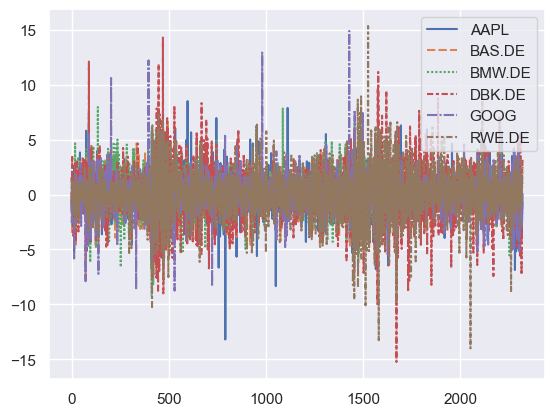

In [13]:
sns.lineplot(data = data);

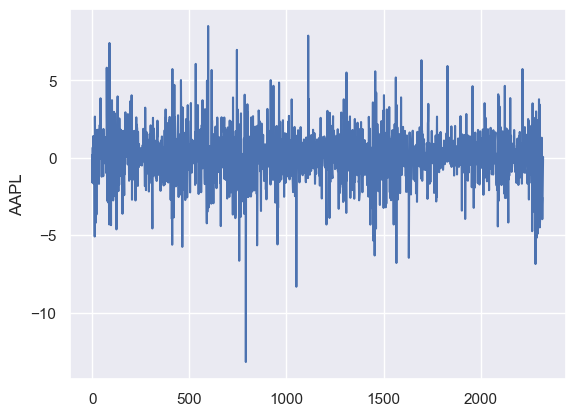

In [14]:
sns.lineplot(data = data.AAPL);

# Simulate random portfolio returns and volatility

In [15]:
m, n = data.shape # m = return periods, n = number of stocks

In [16]:
n_PFs = 500 # number of PFs to simulate

In [17]:
w = np.random.random([n_PFs,n]) # create random PF weights


In [18]:
for i in range(0, n_PFs): # scale so they add up to one
    w[i] = w[i] / w[i].sum()

In [19]:
PFReturns = np.empty(shape = (m, n_PFs))

In [20]:
# calculate simulated PF-Returns

for i in range(0, m):
    for j in range(0, n_PFs):
        PFReturns[i,j] = np.mean(w[j] * data.iloc[i])
        


In [21]:
# calculate means and stds

returns_mean = PFReturns.mean(axis=0)
returns_std = PFReturns.std(axis = 0)

In [22]:
results = pd.DataFrame([returns_mean, returns_std]).T


In [23]:
results.columns = ["mean", "std"]

In [24]:
results.head()

,mean,std
0,0.002953,0.211549
1,0.000787,0.227237
2,0.003347,0.209363
3,0.004299,0.219028
4,0.000632,0.211867


In [25]:
results.shape

(500, 2)

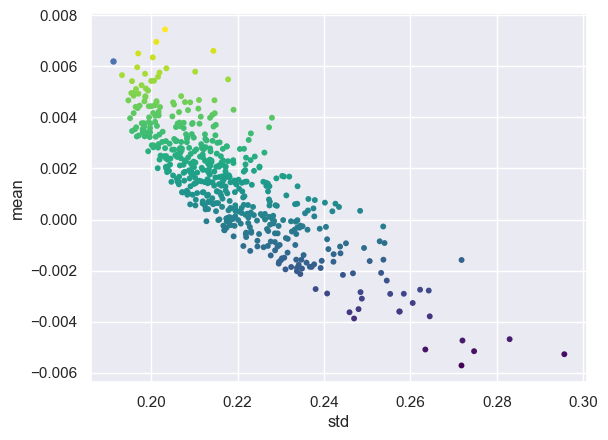

In [61]:
# Plot simulated PF-Returns and stds

sns.scatterplot(y = results["mean"], x = results["std"], size=0.1, linewidth=0, palette="viridis", hue=results["mean"], legend=False)
plt.scatter(x=minvar_returns_std, y = minvar_returns_mean, color="b", s = 13)


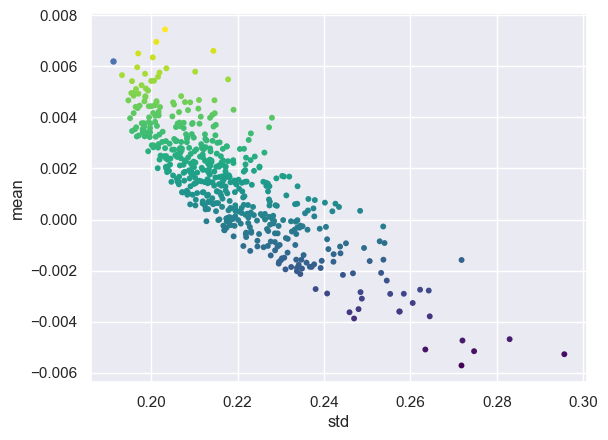

In [80]:
# Plot simulated PF-Returns and stds

sns.scatterplot(y = results["mean"], x = results["std"], size=0.1, linewidth=0, palette="viridis", hue=results["mean"], legend=False)
plt.scatter(x=sigmamin, y = mumin, color="b", s = 13)

# Efficient Frontier

In [27]:
mu = np.mean(data)
Cov = np.cov(data, rowvar=0)
C1 = np.linalg.inv(Cov)

c:\Users\morit\anaconda3\envs\myenv\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [28]:
a = mu.T.dot(C1).dot(mu)
b = np.ones([1,n]).dot(C1).dot(mu)
d = np.ones([1,n]).dot(C1).dot(np.ones([n,1]))

In [29]:
# calculate weights for minimum-variance PF

minvar = (1/d)*C1.dot(np.ones([n,1]))

In [30]:
minvar.shape

(6, 1)

In [31]:
minvar

array([[ 0.26619577],
       [ 0.26832816],
       [ 0.11976027],
       [-0.06353681],
       [ 0.28993868],
       [ 0.11931393]])

In [73]:
sigmamin = 1 / np.sqrt(d)
mumin = b/(d/(1/6))

In [78]:
sigmamin = sigmamin/6

In [79]:
mumin

array([[0.00619657]])

In [35]:
minvar_returns = np.mean(minvar.flatten() * data, axis=1)

In [36]:
minvar_returns_mean = np.mean(minvar_returns)
minvar_returns_std = minvar_returns.std()

In [37]:
minvar_returns_std

0.1912132054073984

In [38]:
minvar_returns_mean

0.006196574781617045

In [42]:
np.sqrt(mumin)

array([[0.19281973]])

In [45]:
mumin**2

array([[0.00138231]])

In [55]:
b/d

array([[0.03717945]])